In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [2]:
df=pd.read_csv(r"C:\Users\Admin\Desktop\NSE-Tata.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,08-10-2020,208.00,222.25,206.85,216.00,215.15,4642146,10062.83
1,05-10-2020,217.00,218.60,205.90,210.25,209.20,3519515,7407.06
2,04-10-2020,223.50,227.80,216.15,217.25,218.20,1728786,3815.79
3,03-10-2020,230.00,237.50,225.75,226.45,227.60,1708590,3960.27
4,01-10-2020,234.55,234.60,221.05,230.30,230.90,1534749,3486.05


In [3]:
# Analyze the closing prices from dataframe:
df["Date"]=pd.to_datetime(df.Date,format="%d-%m-%Y")
df.index=df['Date']


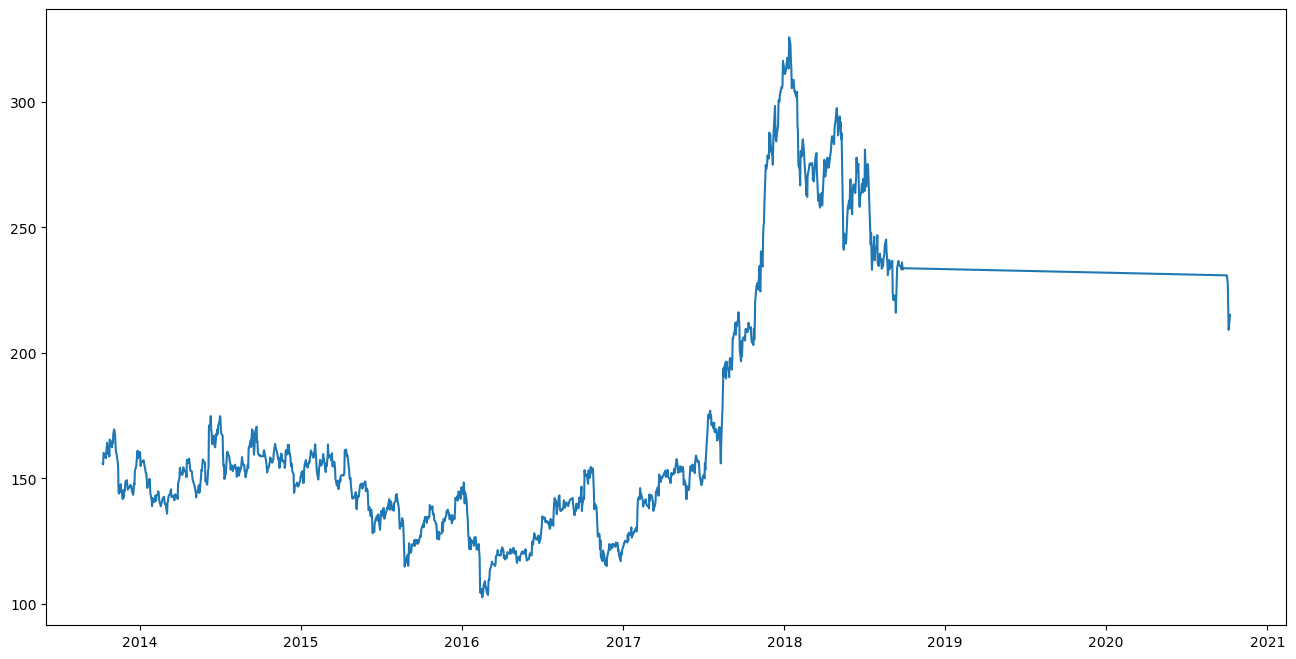

In [4]:
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [17]:
 #Sort the dataset on date time and filter “Date” and “Close” columns:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])


In [6]:
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [7]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values


In [8]:
train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]


In [9]:
new_dataset.index=new_dataset.Date


In [10]:
new_dataset.drop("Date",axis=1,inplace=True)


In [11]:
#Normalize the new filtered dataset:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(new_dataset)

In [12]:
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [13]:
#Build and train the LSTM model:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


927/927 - 43s - 46ms/step - loss: 0.0013


In [14]:
# Take a sample of a dataset to make stock price predictions using the LSTM model:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step


In [15]:
lstm_model.save("saved_model.h5")

C:\Users\Admin\AppData\Local\Temp\ipykernel_12108\107833647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


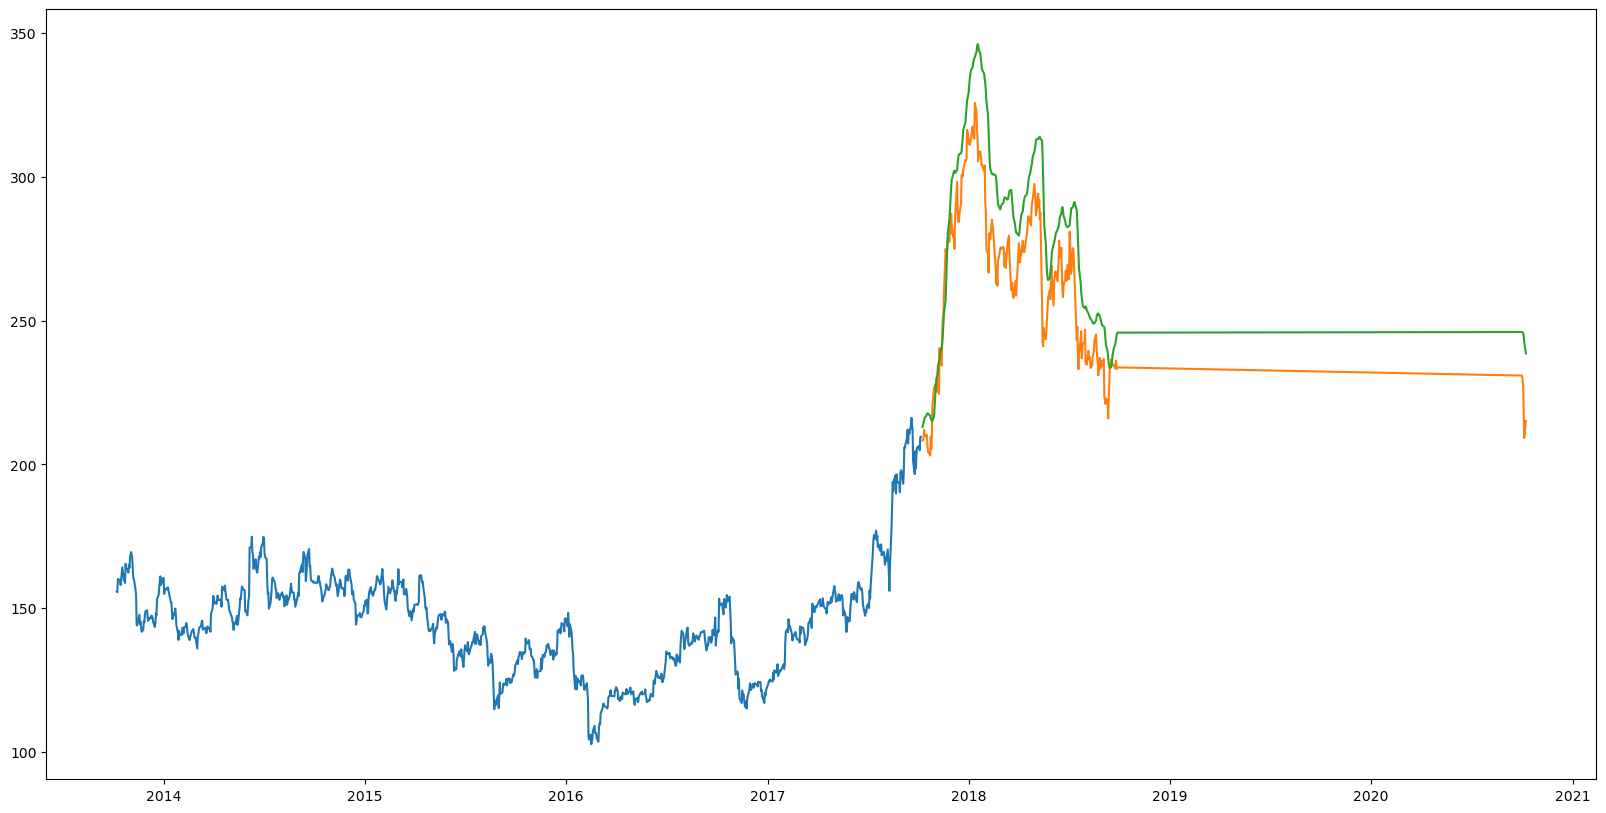

In [16]:
# Visualize the predicted stock costs with actual stock costs:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])